# ALEX17 Diurnal Cycles Benchmark: A Large Domain In Complex Terrain
## Introduction
This is the model evaluation notebook of the ALEX17 benchmark. A guide for participants can be found [here](https://thewindvaneblog.com/alex17-diurnal-cycles-benchmark-a-large-domain-in-complex-terrain-b5029e94485).

## Load libraries

In [17]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from lib.alex17_functions import *  
from lib.nc_read_functions import *  
from scipy import interpolate
from IPython.display import Markdown, display
import rasterio as rio
import matplotlib.pyplot as plt 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Participants

In [3]:
# Read file with simulation descriptions
sims = pd.read_csv('./outputs/alex17_sims.csv')
n_sim = len(sims)

## Input Data
### Elevation Map and Instrument Layout

In [56]:
# Site
siteID = 'alex17'

# Evaluation period
datefrom = datetime.datetime(2018,9,30,0,0,0)    
dateto = datetime.datetime(2018,10,4,0,0,0)  

# Mast positions
masts = pd.read_csv('./inputs/validation_profiles_XYZ.csv') # read {x,y,z} coordinates of target masts
masts = masts.drop(masts[masts['Name']=='WLS70'].index)
         
# Z-transect
Z_transect = pd.read_csv('./inputs/validation_ZTransect_XYZ.csv') # read {x,y,x} coordinates of Z-transect 

# Topography
src = rio.open('./inputs/DTM_Alaiz_2m.tif') # read nc file in UTM coordinates
box = [612000, 622000, 4726000, 4736000]    # evaluation area

# Plot base elevation map and validation sites
#basemap_plot(elevation_map, mast, Z_transect)

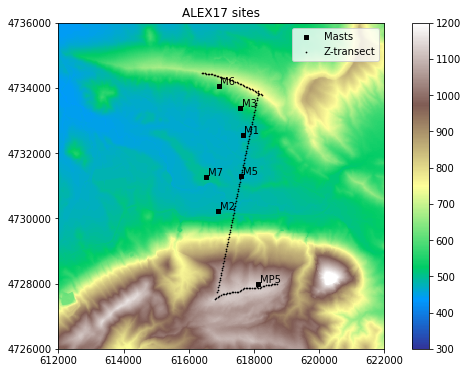

In [84]:
oview = src.overviews(1)[2] # choose overview (0 is largest, -1 is the smallest)
topo = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
spatial_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
topo_ma = np.ma.masked_where(topo == 0 , topo, copy=True) 
fig, ax = plt.subplots(figsize = (10,6))
chm_plot = ax.imshow(topo_ma, cmap='terrain', extent=spatial_extent, vmin=300, vmax=1200) #[left, right, bottom, top]
h_masts = plt.scatter(masts['easting[m]'], masts['northing[m]'], s = 10, marker='s', c='k', label = 'Masts')
h_Z = plt.scatter(Z_transect['easting[m]'], Z_transect['northing[m]'], s = 2, marker='.', c='k', label = 'Z-transect')
for i, txt in enumerate(masts['Name']):
    ax.annotate(txt, (masts['easting[m]'][i]+50, masts['northing[m]'][i]+50))
plt.xlim(box[0:2])
plt.ylim(box[2:4])
plt.title('ALEX17 sites')
plt.legend(handles=[h_masts,h_Z])
colorbar = fig.colorbar(chm_plot, ax=ax)

In [72]:
masts['easting[m]'][0]

618133.3253

In [63]:
box[2:4]

[4726000, 4736000]

In [54]:
masts = masts.drop(masts[masts['Name']=='WLS70'].index)

In [55]:
masts

,Name,easting[m],northing[m],elevation[m]
0,MP5,618133.3253,4727981.062,1123.2667
1,M1,617650.5785,4732567.112,475.3665
2,M2,616901.8801,4730228.629,487.9077
3,M3,617583.4394,4733371.056,529.8882
4,M5,617610.4018,4731298.816,477.7912
5,M6,616915.7087,4734044.400,590.7571
6,M7,616533.0244,4731255.299,499.5788


In [25]:
# Add overviews to raster (https://rasterio.readthedocs.io/en/latest/topics/overviews.html)
#from rasterio.enums import Resampling
#factors = [2, 4, 8, 16]
#dst = rio.open('./inputs/DTM_Alaiz_2m.tif', 'r+')
#dst.build_overviews(factors, Resampling.average)
#dst.update_tags(ns='rio_overview', resampling='average')
#dst.close()

### Mesoscale Input Data
Mesoscale simulations have been produced adopting most of the WRF settings that were used in the production run of the New European Wind Atlas (NEWA). Three one-way nested domains of 27, 9 and 3 km resolution are configured centred at the wind farm centroid. The vertical grid has 61 terrain-following (sigma) levels, with 10 levels covering the first 200 meters, more specifically at: 6, 22, 40, 56, 73, 90, 113, 140, 179 and 205 meters. High resolution topography (SRTM 90m) and updated land use categories (Corine Land Cover 2018), together with the Noah land-surface model are used to define the boundary conditions at the surface. The physical parameterizations are: Mellor–Yamada–Nakanishi Niino 2.5-level planetary boundary-layer scheme (MYNN), WRF Single-Moment 5-class microphysics scheme, the Rapid Radiative Transfer Model for GCMs shortwave and longwave radiation schemes and the Kain-Fritsch cumulus scheme in the outermost domains 1 and 2. The simulation is driven by input data from ERA-5 in blocks of 5 days with additional spin-up time of 24 hours.   

From the 3-km domain we extract output data that will be used as reference in validation plots. This constitute the baseline simulation that we try to improve with microscale modeling. 

In [ ]:
# Load WRFref output data
#f_zt = './outpus/WRFref_zt.nc' # zt profiles
#U_ref_zt, V_ref_zt,S_ref_zt, WD_ref_zt, Th_ref_zt, TKE_ref_zt = read_input(f_zt,datefrom,dateto,['U','V','S','WD','Th','TKE'])

#f_hxyt = './outpus/WRFref_hxyt.nc' # horizontal planes
#U_ref_hxyt, V_ref_hxyt,S_ref_hxyt, WD_ref_hxyt, Th_ref_hxyt, TKE_ref_hxyt = read_input(f_hxyt,datefrom,dateto,['U','V','S','WD','Th','TKE'])

#f_yzt = './outpus/WRFref_yzt.nc' # horizontal planes
#U_ref_yzt, V_ref_yzt,S_ref_yzt, WD_ref_yzt, Th_ref_yzt, TKE_ref_yzt = read_input(f_yzt,datefrom,dateto,['U','V','S','WD','Th','TKE'])

## Validation Data

In [ ]:
# Mast data
#f_zt = './observations/ALEX17_zt.nc'
#U_obs_zt, V_obs_zt,S_obs_zt, WD_obs_zt, Th_obs_zt, TKE_obs_zt = read_input(f_zt,datefrom,dateto,['U','V','S','WD','Th','TKE'])

# Z-Transect data
#f_Zt = './observations/ALEX17_Zt.nc'



In [13]:
f = netCDF4.Dataset('./observations/Nwinds_cup_masts.nc','r')
times = f.variables['Time'][:]
times = netCDF4.num2date(times,f.variables['Time'].units)
#mask = np.logical_and(times >= datefrom, times < dateto)
#idates = np.where(mask)[0]
#times= times[mask]

#U = pd.DataFrame(f.variables['Mast_ID'][idates].data, index = times)
mast_ID = f.variables['Mast ID'][:]
mast_heights = f.variables['Height'][:]
mast_S = f.variables['wind_speed'][:]
mast_S_std = f.variables['wind_speed_std'][:]
mast_WD = f.variables['wind_direction'][:]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: ALEX17 N-winds Cup Masts
    long_title: ALEX17 Diurnal Cycle (N-winds) Benchmark Cup Masts Dataset
    comments: Contact: paas@dtu.dk
    source: Experimental data
    CreationDate: October 2019
    CreatedBy: Pedro Santos
    start_time: 30-Sep-2018 00:00
    end_time: 03-Oct-2018 23:50
    dimensions(sizes): Time(576), Height(5), Mast_ID(2)
    variables(dimensions): float64 Time(Time), float64 Height(Height), float64 Mast ID(Mast_ID), float64 wind_speed(Mast_ID,Height,Time), float64 wind_direction(Mast_ID,Height,Time), float64 wind_speed_std(Mast_ID,Height,Time)
    groups: 

## Simulation Data
We load the simulations defined in *sims* table.  

In [ ]:
U_zt = []; V_zt = []; S_zt = []; WD_zt = []; Th_zt = []; TKE_zt = []
U_hxyt = []; V_hxyt = []; S_hxyt = []; WD_hxyt = []; Th_hxyt = []; TKE_hxyt = []
U_yzt = []; V_yzt = []; S_yzt = []; WD_yzt = []; Th_yzt = []; TKE_yzt = []

for i_sim in range(1,n_sim): # i_sim = 0 is WRFref
    file_name = './outputs/'+ sims["ID"][i_sim] +'.nc'
    f_zt = './outputs/'+ sims["ID"][i_sim] +'_zt.nc' # zt profiles
    U, V, S, WD, Th, TKE = read_input(f_zt,datefrom,dateto,['U','V','S','WD','Th','TKE'])
    U_zt.append(U); V_zt.append(V); S_zt.append(S); WD_zt.append(WD); Th_zt.append(Th); TKE_zt.append(TKE)

    f_hxyt = './outputs/'+ sims["ID"][i_sim] +'_hxyt.nc' # horizontal planes
    U, V, S, WD, Th, TKE = read_input(f_hxyt,datefrom,dateto,['U','V','S','WD','Th','TKE'])
    U_hxyt.append(U); V_hxyt.append(V); S_hxyt.append(S); WD_hxyt.append(WD); Th_hxyt.append(Th); TKE_hxyt.append(TKE)

    f_yzt = './outputs/'+ sims["ID"][i_sim] +'_yzt.nc' # horizontal planes
    U, V, S, WD, Th, TKE = read_input(f_yzt,datefrom,dateto,['U','V','S','WD','Th','TKE'])
    U_yzt.append(U); V_zyt.append(V); S_zyt.append(S); WD_zyt.append(WD); Th_zyt.append(Th); TKE_zyt.append(TKE)


## Compute Quantities of Interest and Metrics

## Results